# Non-Negative Matrix Factorization (NMF)

This module focuses on factorizing and breaking a dataset into individual componenets

# Setup imports and notebook

In [1]:
import matplotlib.pyplot as plt

from imports import *
from run_paths import *

In [2]:
%matplotlib qt
cln_fig = False

In [3]:
%matplotlib inline
cln_fig = True

# Setup Run

In [4]:
# config paths
#########################################
config_path_name = 'unified'
config_name = 'NMF'
#########################################
file_extension = 'h5'

# setup
setup = Setup()
Config, D, M, P = setup.run_config(projects_path, project_name, experiment, config_path_name, config_name)
# standard h5 paths
read_path, write_path = setup.get_path_objects(extension=file_extension)
root_name, node_name = setup.get_tree_objects()
# Load Datacube
datapath = os.path.join(root_name, node_name)
datapath = IO.get_posix_path(datapath)
dc = IO.read_emd(read_path, datapath=datapath, verbose=1)

0038 - 2 185 kx SI 4DSTEM
/
|---reduced
    |---VBF
    |---VDF
    |---VDF_MAX
    |---VDF_SUM
    |---dp_max
    |---dp_mean
    |---static_mask
None


# Parameters

In [5]:
P.__dict__

{'read_path': './h5',
 'name': '0038 - 2 185 kx SI 4DSTEM',
 'node_name': 'reduced',
 'write_path': '',
 'root_name': '0038 - 2 185 kx SI 4DSTEM',
 'test_index': [2, 2],
 'vimg_name': 'VDF_MAX',
 'manual_mask': False,
 'save_results': False}

In [6]:
# test image coordinates
rx, ry = P.test_index

#vimg_name
vimg_name = P.vimg_name

# generate ROI
manual_mask = P.manual_mask

# save results
save_results = P.save_results

# Sample Data
1. generate a real-space ROI indexes
1. get mean/max of these indexes
1. get only those indexes + centers within the ROI

In [7]:
exec(setup.live_update_config(verbose=False))

# generate ROI   # TODO - move mask AFTER physical shifting
dirpath = os.path.dirname(read_path)
img = util.get_image(dc, vimg_name)
msk = None
if manual_mask:
    msk, _ = Utils.draw_static_mask(img.data, dirpath)

min_max [0] (0.0, 2159.73)
min_max [1] (0, 4077)
min_max [2] (0, 2526)


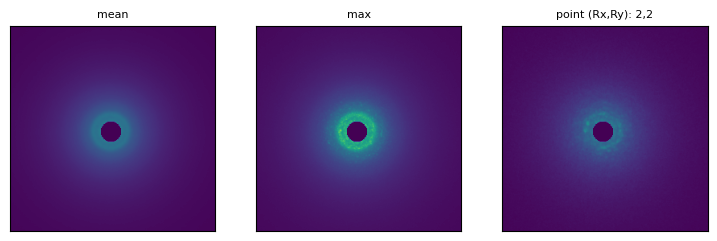

In [8]:

# sample
dp_original = dc.data[rx][ry].copy()  # copy a sample dp after operation
dp_mean = dc.get_virtual_diffraction(
    method="mean",
    mask=msk,
    shift_center=False,
    subpixel=False,
    verbose=True,
    name="dp_mean_masked",
    returncalc=True, )

dp_max = dc.get_virtual_diffraction(
    method="max",
    mask=msk,
    shift_center=False,
    subpixel=False,
    verbose=True,
    name="dp_max_masked",
    returncalc=True, )
# visualize
vis.diffraction([dp_mean.data, dp_max.data, dp_original],
                title=(f'mean', 'max', f'point (Rx,Ry): {ry},{rx}'),
                # markers=markers,
                add_colorbar=False,
                log_scale=False,
                cmap='viridis',
                clean_before=cln_fig,
                num='_inspect',
                vmin=0, vmax=5000,
                figsize=(3, 3))

 # Flatten

### Test round trip and get example from 'mean'

min_max [0] (0.0, 2159.73)
min_max [1] (0.0, 2159.73)


Text(0.5, 1.0, 'Flat - 1D array of a 2D diffraction pattern')

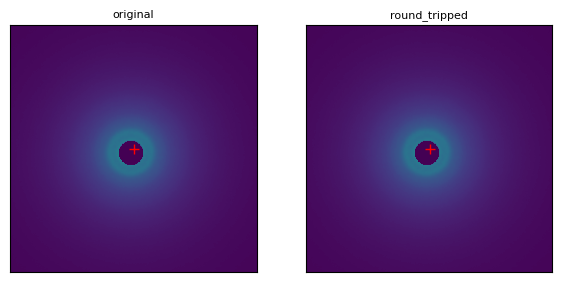

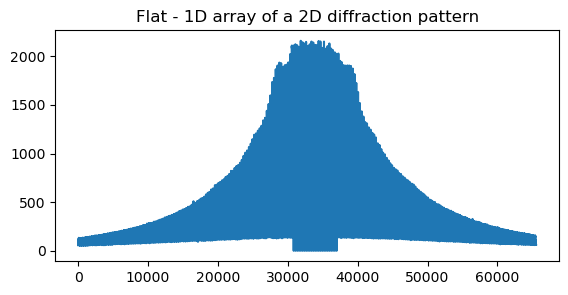

In [9]:
# round trip
gx, gy = icnv.get_center(dp_mean.data, 'geographic_center')  # geographic center
# gx, gy = 135, 115
master_shape = dp_mean.data.shape
_flat_arr = icnv.reshape_2D_to_1D(dp_mean.data)
_reco_img = icnv.reshape_1D_to_2D(_flat_arr, master_shape)
vis.diffraction([dp_mean.data, _reco_img],
                title=(f'original', 'round_tripped'),
                markers=[(gx, gy), (gx, gy), (gx, gy)],
                add_colorbar=False,
                log_scale=False,
                cmap='viridis',
                clean_before=cln_fig,
                num='inspect',
                vmin=0, vmax=5000,
                figsize=(3.5, 3.5))
# array for NMF
fig, ax = plt.subplots(1, 1, num='flat arr', figsize=(6.5, 3))
ax.plot(_flat_arr, '-', ms=1)
ax.set_title('Flat - 1D array of a 2D diffraction pattern')

min_max [0] (0, 4077)
min_max [1] (0, 4077)


Text(0.5, 1.0, 'Flat - 1D array of a 2D diffraction pattern')

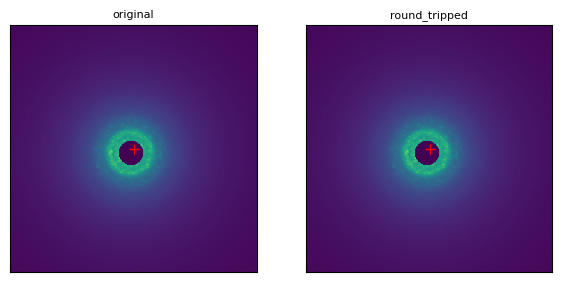

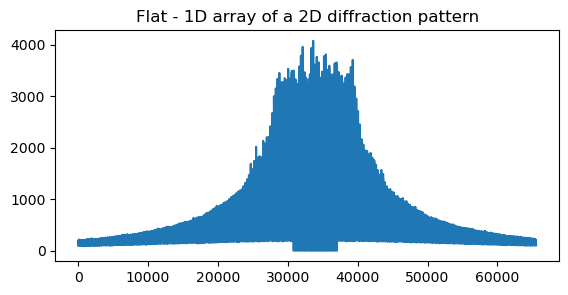

In [10]:
# round trip
gx, gy = icnv.get_center(dp_max.data, 'geographic_center')  # geographic center
# gx, gy = 135, 115
master_shape = dp_max.data.shape
_flat_arr = icnv.reshape_2D_to_1D(dp_max.data)
_reco_img = icnv.reshape_1D_to_2D(_flat_arr, master_shape)
vis.diffraction([dp_max.data, _reco_img],
                title=(f'original', 'round_tripped'),
                markers=[(gx, gy), (gx, gy), (gx, gy)],
                add_colorbar=False,
                log_scale=False,
                cmap='viridis',
                clean_before=cln_fig,
                num='inspect',
                vmin=0, vmax=5000,
                figsize=(3.5, 3.5))
# array for NMF
fig, ax = plt.subplots(1, 1, num='flat arr', figsize=(6.5, 3))
ax.plot(_flat_arr, '-', ms=1)
ax.set_title('Flat - 1D array of a 2D diffraction pattern')

### Create dataset

In [11]:
# test for round trip
if False:
    R_shape = list(ds.shape[:-2])
    Q_shape = list(ds.shape[-2:])
    _flatR = dcnv.flatten_RQ(ds, on_R=True, on_Q=False)
    _flatQ = dcnv.flatten_RQ(ds, on_R=False, on_Q=True)
    _flatRQ = dcnv.flatten_RQ(ds, on_R=True, on_Q=True)
    _R = dcnv.reshape_to_4D(_flatR, dims=R_shape, on_R=True, on_Q=False).shape
    _Q = dcnv.reshape_to_4D(_flatQ, dims=Q_shape, on_R=False, on_Q=True).shape
    _RQ = dcnv.reshape_to_4D(_flatRQ, dims=[R_shape, Q_shape], on_R=True, on_Q=True).shape
    _RQ == _Q == _R

In [12]:
ds = dc.data
flat_ds = dcnv.flatten_RQ(ds, on_R=True, on_Q=True)
flat_ds.shape
# plt.plot(flat_ds[5005], '.', ms=1)
# set up array + masks if needed
data_arr = flat_ds

# PCA

In [27]:
# PCA parameters
N_pca = 2  # number of varience captured by the varience
pca = PCA(n_components=N_pca, whiten=False)
pca.fit(data_arr)

PCA(n_components=2)

[0.25091729 0.01791701]
[0.25091729 0.2688343 ]
(2, 65536)


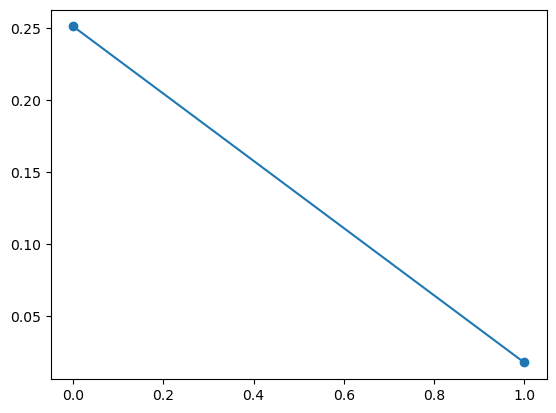

In [28]:
print(pca.explained_variance_ratio_)  # normalized eigen values 
print(np.cumsum(pca.explained_variance_ratio_))  # accumulative normalized eigen values 
print(pca.components_.shape)
plt.plot(pca.explained_variance_ratio_, '-o')  # plotting the pca eigen values

In [29]:
pca_componenets = pca.components_  # all the components 
pca_weights = pca.transform(data_arr)  # normalized eigen vectors 
maps_theme = 'PCA'

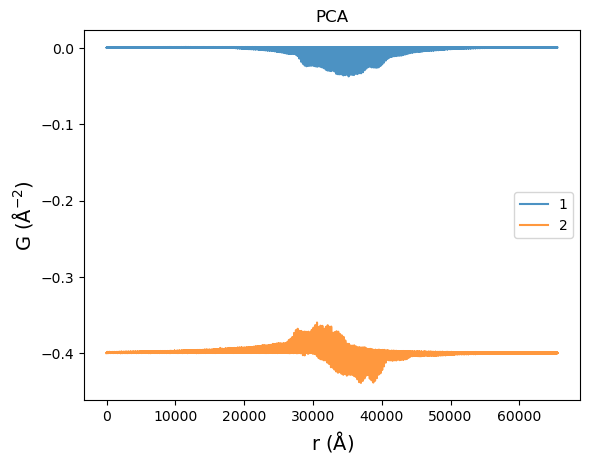

In [30]:
shift = -0.4
s = 0
# colors_ind = [4, 0, 2, 1]
colors_ind = list(range(N_pca))
for i, (comp, ci) in enumerate(zip(pca_componenets, colors_ind), start=1):
    plt.plot(comp + s, c=f"C{ci}", alpha=0.8, label=str(i))
    #     plt.text(max(x[mask])+0.2, s, f'PC\_{i}', fontsize=10)
    plt.xlabel(r'r $(\mathrm{\AA})$', size=14)
    plt.ylabel(r'G $(\mathrm{\AA}^{-2})$', size=14)
    s += shift
plt.title('PCA')
plt.legend()

min_max [0] (-13284.24, 14428.29)
min_max [1] (-4309.75, 4759.67)
min_max [2] (-15016.39, 14059.29)


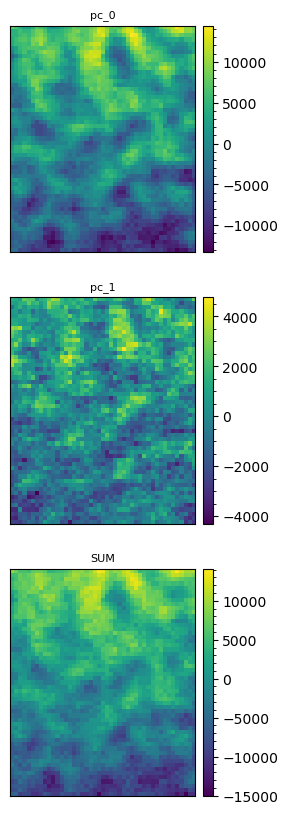

In [32]:
R_shape = list(ds.shape[:-2])
Q_shape = list(ds.shape[-2:])
pca_maps = []
for _map in pca_weights.T:
    _map = icnv.reshape_1D_to_2D(_map, R_shape)
    pca_maps.append(_map)
pca_maps.append(sum(pca_maps))
titels = list(f'pc_{i}' for i in range(N_pca))
titels.append('SUM')
vis.diffraction(pca_maps,
                title=titels,
                add_colorbar=True,
                log_scale=False,
                cmap='viridis',
                clean_before=cln_fig,
                stack_view=True,
                num='PCA',
                # vmin=0, vmax=5,
                figsize=(8, 10))

# NMF

In [33]:
# nulify negative values
if True:
    data_arr = data_arr.clip(0) 
# add most negative value
if False:
    data_arr = data_arr+np.abs(data_arr.min())

In [34]:
N_nmf = 3 # number of varience captured by the varience
nmf = NMF(N_nmf, max_iter=400, tol=1e-3, alpha_W=0, alpha_H='same', l1_ratio=0)
nmf.fit(data_arr)
nmf_componenets = nmf.components_
nmf_weights = nmf.transform(data_arr)
nmf_rec_err = nmf.reconstruction_err_
print(nmf_rec_err)

486336.63109002245


In [35]:
nmf_weights.shape

(2475, 3)

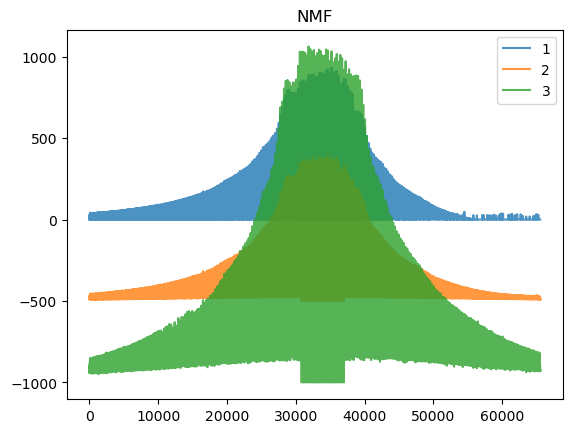

In [36]:
shift = -500
s = 0
# colors_ind = [4, 0, 2, 1]
colors_ind = list(range(N_nmf))
nmf_comp_images = list()
for i, (comp, ci) in enumerate(zip(nmf_componenets, colors_ind), start=1):
    nmf_comp_images.append(icnv.reshape_1D_to_2D(comp, master_shape)+1)
    plt.plot(comp + s, c=f"C{ci}", alpha=0.8, label=str(i))
    #     plt.text(max(x[mask])+0.2, s, f'PC\_{i}', fontsize=10)
    s += shift
plt.title('NMF')
plt.legend()



min_max [0] (1.0, 932.88)
min_max [1] (1.0, 887.21)
min_max [2] (1.0, 2062.8)


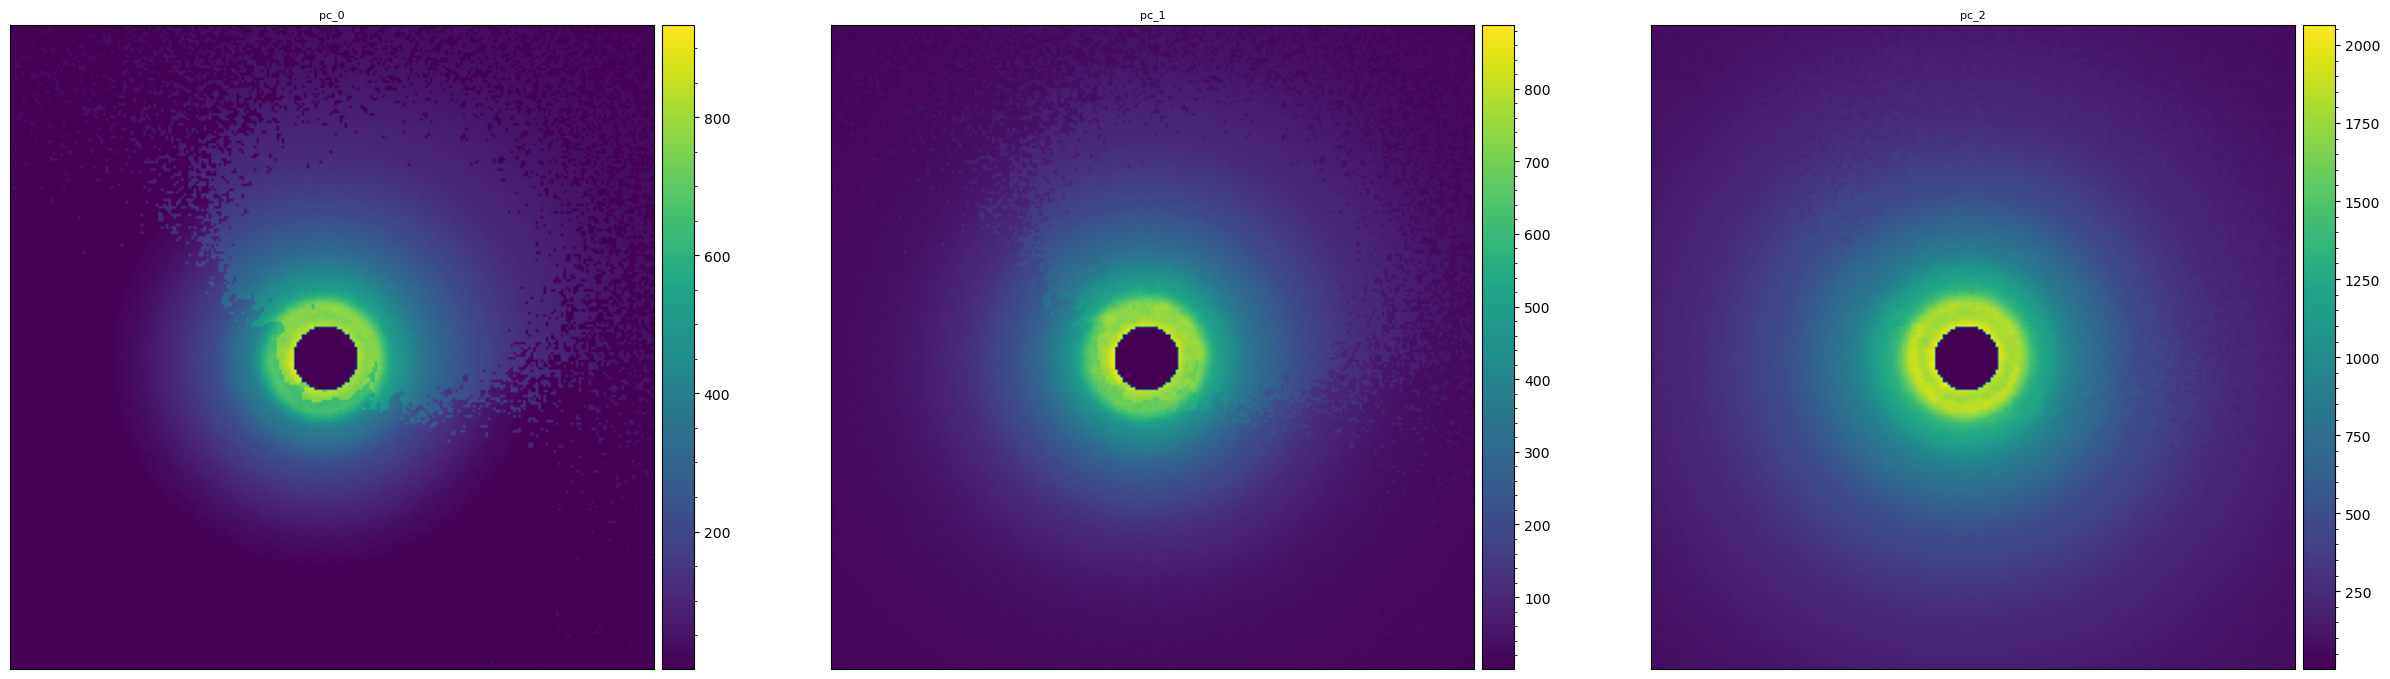

In [42]:
vis.diffraction(nmf_comp_images,
                title=list(f'pc_{i}' for i in range(N_nmf)),
                add_colorbar=True,
                cmap='viridis',
                clean_before=cln_fig,
                stack_view=False,
                shareax=True,
                num='NMF_comp',
                # log_scale=True,
                # vmin=0, vmax=9000,
                figsize=(10, 30))

min_max [0] (1.0, 1.0)
min_max [1] (1.01, 2.53)
min_max [2] (1.54, 1.92)


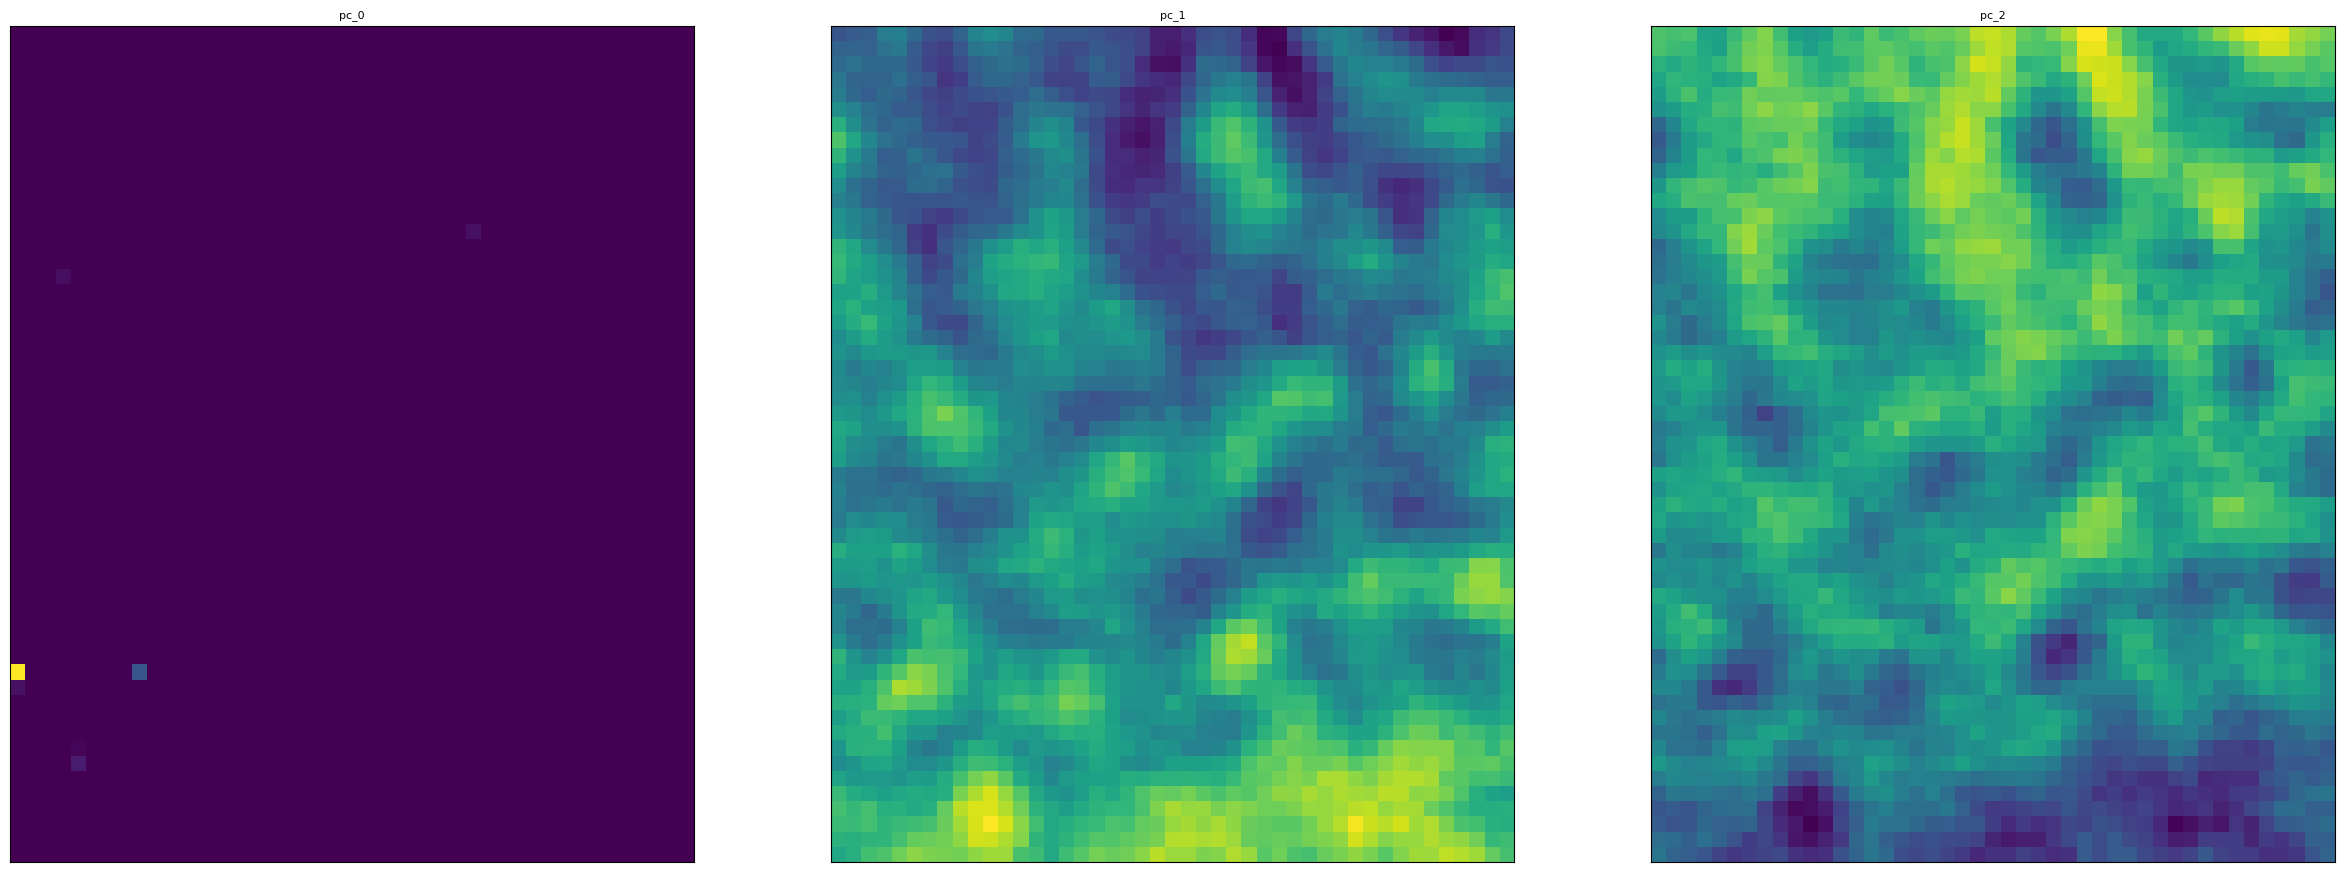

In [38]:
R_shape = list(ds.shape[:-2])
Q_shape = list(ds.shape[-2:])
nmf_maps = []
counter = 1
for _map in nmf_weights.T:
    counter+=1
    _map = icnv.reshape_1D_to_2D(_map, R_shape)
    nmf_maps.append(_map + 1)
# nmf_maps.append(sum(nmf_maps))
titles = list(f'pc_{i}' for i in range(N_nmf))
titles.append('SUM')

if True:
    vis.diffraction(nmf_maps,
                title=titles,
                # add_colorbar=True,
                # log_scale=True,
                # axes_vis=True,
                cmap='viridis',
                clean_before=cln_fig,
                # stack_view=True,
                shareax=True,
                num='NMF_weights',
                # vmin=-0.1, vmax=1.3,
                # vmin=0, vmax=4,
                figsize=(10, 20))

if False:  
    get_ar = lambda x: nmf_maps[x]
    H=int(counter/2)
    W=int(counter/2)
    
    p4ds.visualize.show_image_grid(get_ar,
                                   H=H, 
                                   W=W,
                                   title=titles,
                                   cmap='viridis',
                                   scalebar=True,
                                   scaling='log',
                                   vmin=0, vmax=1,
                                   axsize=(10,30))




In [1]:
selected = nmf_maps[1]+nmf_maps[2]
vis.diffraction(selected,
                title=list(f'pc_{i}' for i in range(N_nmf)),
                add_colorbar=True,
                log_scale=True,
                cmap='viridis',
                clean_before=cln_fig,
                stack_view=True,
                shareax=False,
                num='_inspect_selected',
                # vmin=0, vmax=500,
                figsize=(5, 5))


NameError: name 'nmf_maps' is not defined

In [ ]:
p4ds.show(selected, scalebar={}, calibration=dc.calibration, space='R', cmap='viridis', vmin=0, vmax=0.9999)



# Save

In [ ]:
# # save processed data and collect relevant run configs
# if save_results:
#     util.save_processed_data(dc.root, write_path, Config.__dict__)
#     input("Saved!")
# else:
#     input("Done, NOT Saved.")